In [2]:
train_dir = './dataset/training'
test_dir = './dataset/test'

In [3]:
import torchvision.transforms as transforms
from torchvision import datasets

transforms = transforms.Compose([transforms.Resize(256), 
                                 transforms.RandomCrop(224),
                                 transforms.Resize(128), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.ImageFolder(train_dir, transform=transforms)
testset = datasets.ImageFolder(test_dir, transform=transforms)

In [4]:
trainset.classes

['cats', 'dogs']

In [5]:
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))
np.random.seed(0)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,sampler=train_sampler,
                                           num_workers=2)

validloader = torch.utils.data.DataLoader(trainset, batch_size=512,sampler=valid_sampler,
                                           num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=512)

In [7]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    
        self.hidden = nn.Linear(3*128*128, 256)      
        self.output = nn.Linear(256,2)

    def forward(self, x):
        
        N = x.shape[0]
        x = x.view(N, -1)
        
        x = self.hidden(x)                
        
        x = torch.sigmoid(x)        
        
        x = self.output(x)        
        return x

model = Net()


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [9]:
epochs = 10
train_losses = np.zeros(epochs)
valid_losses = np.zeros(epochs)

for epoch in range(epochs):  

    model.train()
    train_loss = []     
    for data in trainloader:
        
        inputs, labels = data
                        
        optimizer.zero_grad()

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        train_loss.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        valid_loss = []
        for data in validloader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
            valid_loss.append(loss.item())
    
    train_loss = np.mean(train_loss)
    valid_loss = np.mean(valid_loss)
    
    print( 'Epoch [%d] train loss: %.3f  valid loss: %.3f' %
         (epoch + 1, train_loss, valid_loss ))
    
    train_losses[epoch] = train_loss
    valid_losses[epoch] = valid_loss
print('Finished Training')

C:\Users\user\anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch [1] train loss: 1.332  valid loss: 0.911
Epoch [2] train loss: 0.823  valid loss: 0.711
Epoch [3] train loss: 0.726  valid loss: 0.699
Epoch [4] train loss: 0.692  valid loss: 0.681
Epoch [5] train loss: 0.688  valid loss: 0.676
Epoch [6] train loss: 0.684  valid loss: 0.676
Epoch [7] train loss: 0.682  valid loss: 0.672
Epoch [8] train loss: 0.680  valid loss: 0.682
Epoch [9] train loss: 0.677  valid loss: 0.682
Epoch [10] train loss: 0.680  valid loss: 0.681
Finished Training


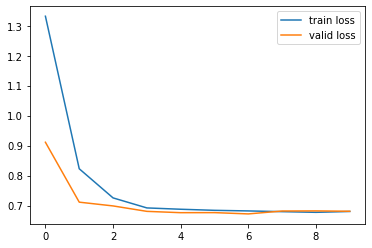

In [10]:
# Plot the train loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.legend()
plt.show()

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
                                                  100 * correct / total))

Accuracy of the network on the test images: 56 %


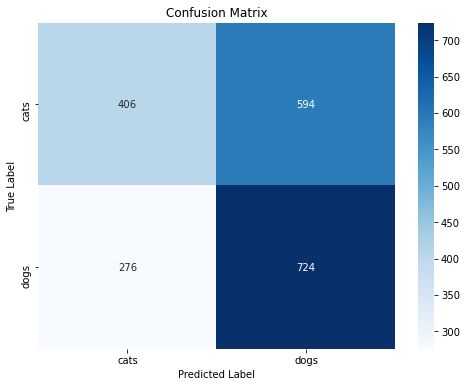

In [12]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test = testset.targets
p_test = np.array([])

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        p_test = np.concatenate((p_test, predicted.numpy()))  


cm = confusion_matrix(y_test, p_test)

plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
ax = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
ax.set(ylabel="True Label", xlabel="Predicted Label")
ax.set_xticklabels(testset.classes)
ax.set_yticklabels(testset.classes)
plt.show()